In [2]:
import pyreadstat
import pandas as pd
import numpy as np
from statsmodels.nonparametric.kernel_regression import KernelReg
from sklearn import neighbors
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
df, meta = pyreadstat.read_sav("~/Downloads/statewise_cnns/Rajasthan_cnns.sav")
column_desc = meta.column_names_to_labels
var_value_desc = meta.variable_value_labels

In [4]:
'''
print(column_desc)
print(var_value_desc)

'''

'\nprint(column_desc)\nprint(var_value_desc)\n\n'

In [5]:
df.to_csv("output_file_n.csv", index=False)

In [6]:
#Taking mid upper arm circumference as dependent variable and regressing on age, vitamin A and wealth index

In [7]:
#Dropping missing values

In [8]:
df_bio = df.dropna(subset = ['state_weight_bio'])

In [9]:
df_bio = df_bio.dropna(subset = ['vitaa_unic'])
df_bio_cleaned = df_bio[df_bio.vitaa_unic > 0]
df_bio_cleaned = df_bio[df_bio.vitaa_unic < 9999]
df_bio_final = df_bio_cleaned.dropna(subset = ['muac'])

In [10]:
df_bio_final.to_csv("bio_sample_file.csv", index=False)

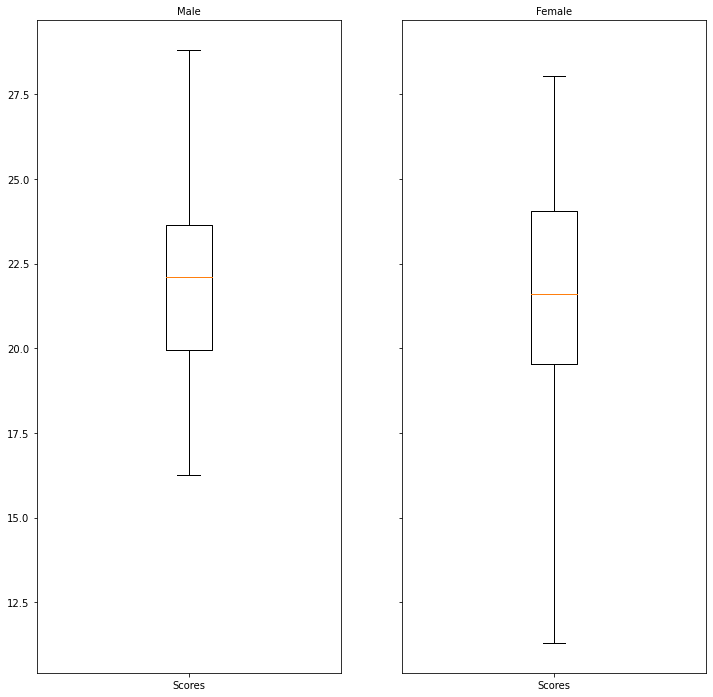

In [11]:
def boxplot(values, freqs,title):
    values = np.array(values)
    freqs = np.array(freqs)
    arg_sorted = np.argsort(values)
    values = values[arg_sorted]
    freqs = freqs[arg_sorted]
    count = freqs.sum()
    fx = values * freqs
    mean = fx.sum() / count
    variance = ((freqs * values ** 2).sum() / count) - mean ** 2
    variance = count / (count - 1) * variance  # dof correction for sample variance
    std = np.sqrt(variance)
    minimum = np.min(values)
    maximum = np.max(values)
    cumcount = np.cumsum(freqs)

    #print([std, variance])
    Q1 = values[np.searchsorted(cumcount, 0.25 * count)]
    Q2 = values[np.searchsorted(cumcount, 0.50 * count)]
    Q3 = values[np.searchsorted(cumcount, 0.75 * count)]

    IQR = Q3 - Q1

    whishi = Q3 + 1.5 * IQR
    whislo = Q1 - 1.5 * IQR

    stats = [{
        'label': 'Scores',  # tick label for the boxplot
        'mean': mean,  # arithmetic mean value
        'iqr': Q3 - Q1,  # 5.0,
#         'cilo': 2.0,  # lower notch around the median
#         'cihi': 4.0,  # upper notch around the median
        'whishi': maximum,  # end of the upper whisker
        'whislo': minimum,  # end of the lower whisker
        'fliers': [],  # '\array([], dtype=int64)',  # outliers
        'q1': Q1,  # first quartile (25th percentile)
        'med': Q2,  # 50th percentile
        'q3': Q3  # third quartile (75th percentile)
    }]
    
    return stats

b1 = boxplot(df_bio_final[df_bio_final.q102 == 1]['muac'], df_bio_final['state_weight_bio'], 'male')
b2 = boxplot(df_bio_final[df_bio_final.q102 == 2]['muac'], df_bio_final['state_weight_bio'], 'female')

fs = 10  # fontsize
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 12), sharey=True)
axes[0].bxp(b1)
axes[1].bxp(b2)
axes[0].set_title('Male', fontsize=fs)
axes[1].set_title('Female',fontsize = fs)
plt.show()


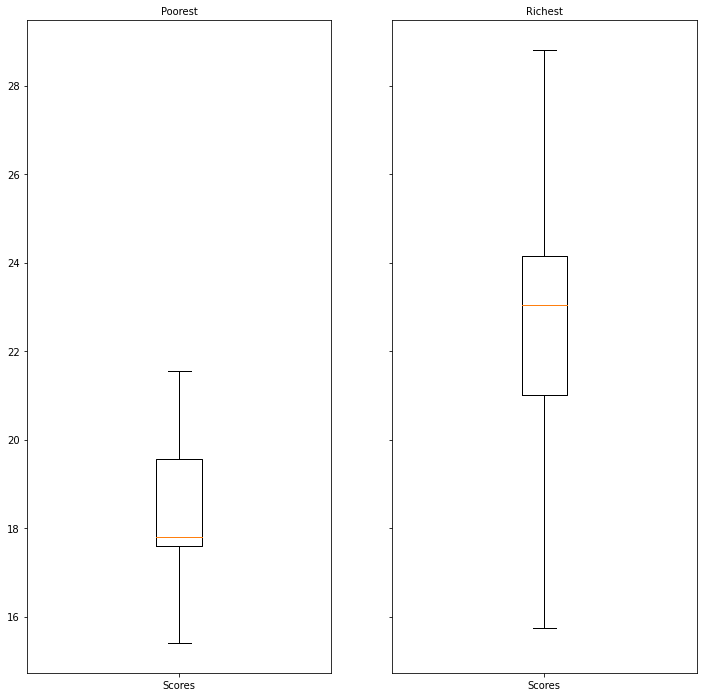

In [12]:
c1 = boxplot(df_bio_final[df_bio_final.wi == 1]['muac'], df_bio_final['state_weight_bio'], 'Poorest')
c2 = boxplot(df_bio_final[df_bio_final.wi == 5]['muac'], df_bio_final['state_weight_bio'], 'Richest')

fs = 10  # fontsize
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 12), sharey=True)
axes[0].bxp(c1)
axes[1].bxp(c2)
axes[0].set_title('Poorest', fontsize=fs)
axes[1].set_title('Richest',fontsize = fs)
plt.show()

<AxesSubplot:xlabel='muac', ylabel='vitaa_unic'>

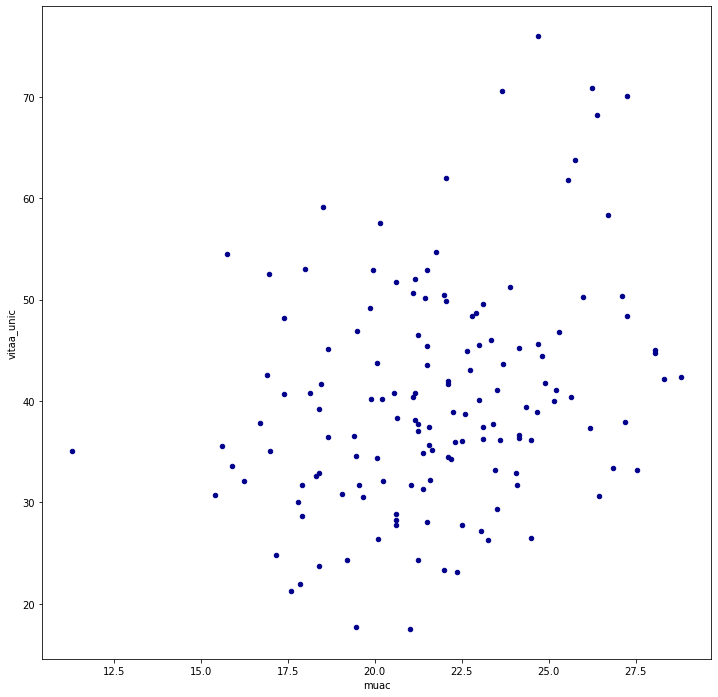

In [13]:
df_bio_final.plot.scatter(x='muac',y='vitaa_unic',c='Darkblue',figsize = (12,12))

## Weighted correlation

In [14]:
def m(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)

def cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - m(x, w)) * (y - m(y, w))) / np.sum(w)

def corr(x, y, w):
    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))


In [15]:
print(corr(df_bio_final['vitaa_unic'],df_bio_final['muac'],df_bio_final['state_weight_bio']))

0.40670567866367313


## WLS Regression 

In [16]:
X = df_bio_final[['vitaa_unic','q104','wi','state_weight_bio']]
Y = df_bio_final['muac']
X = sm.add_constant(X) #adding constant
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42) #to keep train sample same in all runs
fit_wls = sm.WLS(y_train, X_train[['const','vitaa_unic','q104','wi']], weights = X_train['state_weight_bio']).fit()
print(fit_wls.summary())
fit_robust = fit_wls.get_robustcov_results(cov_type='HAC',maxlags=2)
print(fit_robust.summary())
y_pred = fit_wls.predict(X_test[['const','vitaa_unic','q104','wi']])

                            WLS Regression Results                            
Dep. Variable:                   muac   R-squared:                       0.445
Model:                            WLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                     29.37
Date:                Sat, 20 May 2023   Prob (F-statistic):           5.03e-14
Time:                        15:25:39   Log-Likelihood:                -264.97
No. Observations:                 114   AIC:                             537.9
Df Residuals:                     110   BIC:                             548.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.8985      1.296      7.638      0.0

In [17]:
mse = mean_squared_error(y_test, y_pred)
print("Mean squared error: ", mse)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mse)
print("Root mean squared error: ", rmse)

Mean squared error:  8.09460692556515
Root mean squared error:  2.845102269790165


## Kernel Regression

In [18]:
#Gaussian Kernel
def gauss(x,p,h):
    return np.exp(-(np.power((x-p)/h,2)))/(np.sqrt(2*np.pi))

In [19]:
#Categorical kernel
def cat(x,p,h,c):
    if(x==p):
        return 1-h
    else:
        return h/(c-1)

In [20]:
#Ordered Discrete Kernel
def ordered(x,p,h):
    return np.power(h,np.absolute(x-p))

In [21]:
X = df_bio_final[['vitaa_unic','q104','wi','muac','state_weight_bio']]
Y = df_bio_final['muac']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [22]:
def predicted(bc,bmi,q104,wi, state_weight_bio,df, h,c,o):
    pred = 0
    loo_pred = 0
    sum_kernels = 0
    for i in range(0,len(df)):
        kernel_weight = gauss(df.iloc[i]['vitaa_unic'],bmi,h)*cat(df.iloc[i]['wi'],wi,5,c)*ordered(df.iloc[i]['q104'],q104,o)
        pred = pred + df.iloc[i]['muac']*df.iloc[i]['state_weight_bio']*kernel_weight
        sum_kernels = sum_kernels + kernel_weight*df.iloc[i]['state_weight_bio']
    
    final_pred = pred/(sum_kernels)
    kw = gauss(bmi,bmi,h)*cat(wi,wi,5,c)*ordered(q104,q104,o)*state_weight_bio
    loo_pred = pred - bc*kw
    loo_pred = loo_pred/(sum_kernels -kw)
    

    return final_pred,loo_pred

In [23]:
h=5
c=0.98
o=0.44
pred_list = []
loo_pred_list = []
pred_error = []
for i in range(0,len(X_train)):
    pred,loo = predicted(X_train.iloc[i]['muac'],X_train.iloc[i]['vitaa_unic'],X_train.iloc[i]['q104'],X_train.iloc[i]['wi'],X_train.iloc[i]['state_weight_bio'],X_train,h,c,o)
    pred_list.append(pred)
    loo_pred_list.append(loo)
    pred_error.append(np.power(X_train.iloc[i]['muac']-loo,2))

X_train['pred'] = pred_list
X_train['loo'] = loo_pred_list
X_train['error'] = pred_error

mean_pred_error = X_train["error"].mean()
print("Leave one out prediction error :" , mean_pred_error)

Leave one out prediction error : 6.300838382022991


In [24]:
# Above steps replicated for test data

test_pred_list = []
for i in range(0,len(X_test)):
    pred,loo = predicted(X_test.iloc[i]['muac'],X_test.iloc[i]['vitaa_unic'],X_test.iloc[i]['q104'],X_test.iloc[i]['wi'],X_test.iloc[i]['state_weight_bio'],X_test,h,c,o)
    test_pred_list.append(pred)

y_pred = test_pred_list

mse = mean_squared_error(y_test, y_pred)
print("Mean squared error: ", mse)
rmse = np.sqrt(mse)
print("Root mean squared error: ", rmse)

Mean squared error:  10.516795612511645
Root mean squared error:  3.2429609329302203


In [25]:
#Nadaraya-Watson-Estimator
X = df_bio_final[['vitaa_unic','q104','wi']]
Y = df_bio_final['muac']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
#print(X_train)
#kr = KernelReg(endog=Y, exog=X , var_type='cou',bw = [0.1,0.9,0.4],reg_type='lc')
kr = KernelReg(endog=Y, exog=X , var_type='cou',reg_type='lc')
#ksrmv1 = KernelReg(endog=final_df['wc'], exog=final_df[['muac']] , var_type='c',reg_type='lc')

In [26]:
print("R squared model fit ", kr.r_squared())
print(kr.bw)
print(kr.cv_loo(kr.bw,kr._est_loc_constant))

R squared model fit  0.3275260991117842
[5.00471359 0.44530505 0.98233151]
[6.88673197]
